In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.inspection import permutation_importance


In [ ]:
# Cargar los datos
train = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')
oot = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')
prob = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')
master = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_master_customer_data_enmascarado_completa.csv')
pagos = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv')
sample_sub = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/sample_submission.csv')


In [ ]:
# Mostrar dimensiones de cada set
shapes = pd.DataFrame({
    'Dataset': ['train', 'oot', 'prob', 'master', 'pagos'],
    'Rows': [train.shape[0], oot.shape[0], prob.shape[0], master.shape[0],pagos.shape[0]],
    'Columns': [train.shape[1], oot.shape[1], prob.shape[1], master.shape[1], pagos.shape[1]]
})
print("Dimensiones de los datasets:")
display(shapes)

# Inspección de columnas y primeras filas de train y master
print("\nColumnas de train:")
print(train.columns.tolist())
print("\nPrimeras 5 filas de train:")
display(train.head())

print("\nColumnas de prob:")
print(prob.columns.tolist())
print("\nPrimeras 5 filas de prob:")
display(prob.head())

print("\nColumnas de master:")
print(master.columns.tolist())
print("\nPrimeras 5 filas de master:")
display(master.head())

print("\nColumnas de pagos:")
print(pagos.columns.tolist())
print("\nPrimeras 5 filas de pagos:")
display(pagos.head())



Dimensiones de los datasets:


,Dataset,Rows,Columns
0,train,568251,49
1,oot,112549,4
2,prob,4804836,7
3,master,430000,37
4,pagos,4855035,13



Columnas de train:
['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt', 'var_rpta_alt', 'tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons', 'aplicativo', 'min_mora', 'max_mora', 'dias_mora_fin', 'rango_mora', 'vlr_obligacion', 'vlr_vencido', 'saldo_capital', 'endeudamiento', 'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3', 'cant_alter_posibles', 'alter_posible1_2', 'alter_posible2_2', 'alter_posible3_2', 'cant_gestiones', 'cant_gestiones_binario', 'rpc', 'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo', 'cant_acuerdo_binario', 'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult', 'marca_alt_rank', 'marca_alt_apli', 'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes', 'porc_pago_mes', 'pagos_tanque', 'marca_debito_mora', 'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'marca_pago', 'marca_alternativa', 'marca_alternativa_orig']

Primeras 5 filas de train:


,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,...,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig
0,630611,219718,863073,202308,1,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,...,0.095438,0.0,0.000000,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa
1,59412,789567,290775,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,NaN,Sin pago,NO,PRORROGA,MANTENIMIENTO,Sin pago,Acepta Alternativa,Acepta Alternativa
2,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,Acepta Alternativa,Acepta Alternativa
3,26897,585786,494556,202311,1,a_uno_tipo_1,Banca Personas,Personal,ROTATIVOS,Rotativos,...,0.042117,4090.0,0.015324,Con pago,NO,PRORROGA,MANTENIMIENTO,Pago parcial,Acepta Alternativa,Acepta Alternativa
4,24588,1061389,18953,202311,1,b_uno_tipo_2,Banca Personas,Personal plus,ROTATIVOS,Rotativos,...,0.000000,0.0,0.000000,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa



Columnas de prob:
['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte', 'lote', 'prob_propension', 'prob_alrt_temprana', 'prob_auto_cura']

Primeras 5 filas de prob:


,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura
0,296482,102381,202308,1,0.761350,0.193744,0.684784
1,391957,742315,202310,2,0.741803,0.384184,0.483696
2,229894,359919,202307,1,0.835373,0.285157,0.826225
3,478963,239064,202303,3,0.445002,0.629652,0.346508
4,349609,923348,202308,2,0.784365,0.419123,0.667603



Columnas de master:
['nit_enmascarado', 'cod_tipo_doc', 'tipo_cli', 'ctrl_terc', 'genero_cli', 'ano_nac_cli', 'edad_cli', 'estado_civil', 'tipo_vivienda', 'num_hijos', 'personas_dependientes', 'nivel_academico', 'ocup', 'act_econom', 'sector', 'subsector', 'declarante', 'total_ing', 'tot_activos', 'tot_pasivos', 'origen_fondos', 'f_vinc', 'f_ult_mantenimiento', 'canal_actualizacion', 'cli_actualizado', 'segm', 'subsegm', 'nicho', 'region_of', 'nombre_dpto_dirp', 'egresos_mes', 'tot_patrimonio', 'ciiu', 'smmlv', 'year', 'month', 'ingestion_day']

Primeras 5 filas de master:


,nit_enmascarado,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,...,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,year,month,ingestion_day
0,536377,1,PERSONA NATURAL,CLIENTE,F,1998.0,25.0,SOLTERO,FAMILIAR,0.0,...,MUJERES,CENTRO,SANTANDER,0.0,33750000.0,NaN,1160000.0,2023,12,31
1,512257,1,PERSONA NATURAL,CLIENTE,F,1984.0,38.0,UNION LIBRE,PROPIA,0.0,...,MUJERES,CARIBE,MAGDALENA,250000.0,5000000.0,ASALARIADOS,1160000.0,2023,9,30
2,5788,1,PERSONA NATURAL,CLIENTE SOCIAL,M,1960.0,63.0,NaN,NaN,0.0,...,NaN,DIRECCIÓN GENERAL,SIN INFORMACION,0.0,0.0,ASALARIADOS,1160000.0,2023,11,30
3,132245,1,PERSONA NATURAL,CLIENTE,F,1982.0,41.0,CASADO,NaN,1.0,...,MUJERES,SUR,VALLE,1000000.0,62513000.0,ASALARIADOS,1160000.0,2023,7,31
4,245279,1,PERSONA NATURAL,CLIENTE,M,1980.0,43.0,CASADO,ALQUILADA,0.0,...,NaN,BOGOTA Y CUNDINAMARCA,CALDAS,1000000.0,34135000.0,ASALARIADOS,1160000.0,2023,12,31



Columnas de pagos:
['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte', 'producto', 'aplicativo', 'segmento', 'valor_cuota_mes', 'pago_total', 'fecha_pago_minima', 'fecha_pago_maxima', 'porc_pago', 'marca_pago', 'ajustes_banco']

Primeras 5 filas de pagos:


,nit_enmascarado,num_oblig_enmascarado,fecha_corte,producto,aplicativo,segmento,valor_cuota_mes,pago_total,fecha_pago_minima,fecha_pago_maxima,porc_pago,marca_pago,ajustes_banco
0,482906,362297,20230731,CARTERA MICROCREDITO,L,MICROPYME,311950.0,1862788.0,20230621.0,20230721.0,597.0,PAGO_MENOS,NO
1,121735,186855,20230228,LIBRE INVERSION,L,SOCIAL,131030.0,264157.0,20230127.0,20230207.0,202.0,PAGO_MENOS,NO
2,582719,675503,20231031,TARJETA DE CREDITO,K,PERSONAL,1405339.0,3320.0,20231003.0,20231003.0,0.0,PAGO_MENOS,NO
3,299903,107931,20230228,ROTATIVOS,L,PERSONAL PLUS,19220.0,0.0,NaN,NaN,0.0,FACTURACION_MES_SGTE,NO
4,88625,566060,20230430,ROTATIVOS,L,PERSONAL,384684.0,769368.0,20230403.0,20230403.0,200.0,PAGO_MAS,NO


### Preparacion de los dataframes

In [ ]:

# Train: convertir YYYYMM a última fecha del mes
train['fecha_var_rpta_dt'] = (
    pd.to_datetime(train['fecha_var_rpta_alt'].astype(str) + '01', format='%Y%m%d')
      + pd.offsets.MonthEnd(0)
)

# Prob: convertir YYYYMM a última fecha del mes
prob['fecha_corte_dt'] = (
    pd.to_datetime(prob['fecha_corte'].astype(str) + '01', format='%Y%m%d')
      + pd.offsets.MonthEnd(0)
)

# Pagos solo parsear 
pagos['fecha_corte_dt'] = pd.to_datetime(pagos['fecha_corte'], format='%Y%m%d')

# --- 5️⃣ Master: concatenar year, month, ingestion_day y parsear 
master['ingestion_date_dt'] = pd.to_datetime(
    master['year'].astype(str).str.zfill(4) +
    master['month'].astype(str).str.zfill(2) +
    master['ingestion_day'].astype(str).str.zfill(2),
    format='%Y%m%d'
)

# Verificación de que es fin de mes
master['is_month_end'] = master['ingestion_date_dt'] == master['ingestion_date_dt'] + pd.offsets.MonthEnd(0)

# Filtrar aquellos que NO sean fin de mes
not_eom = master[~master['is_month_end']]

# Mostrar ejemplos 
print("Train:", train[['fecha_var_rpta_alt','fecha_var_rpta_dt']].head(3))
print("Prob: ", prob[['fecha_corte','fecha_corte_dt']].head(3))
print("Pagos:", pagos[['fecha_corte','fecha_corte_dt']].head(3))
print("Master:", master[['year','month','ingestion_day','ingestion_date_dt','is_month_end']].head(3))
print('*'*100)
print("Número de registros que NO caen en fin de mes para master:", len(not_eom))



Train:    fecha_var_rpta_alt fecha_var_rpta_dt
0              202308        2023-08-31
1              202312        2023-12-31
2              202312        2023-12-31
Prob:     fecha_corte fecha_corte_dt
0       202308     2023-08-31
1       202310     2023-10-31
2       202307     2023-07-31
Pagos:    fecha_corte fecha_corte_dt
0     20230731     2023-07-31
1     20230228     2023-02-28
2     20231031     2023-10-31
Master:    year  month  ingestion_day ingestion_date_dt  is_month_end
0  2023     12             31        2023-12-31          True
1  2023      9             30        2023-09-30          True
2  2023     11             30        2023-11-30          True
****************************************************************************************************
Número de registros que NO caen en fin de mes para master: 0


In [ ]:

# Agregado de probabilidades usando merge por 3 llaves
prob_ext = pd.merge(
    train[['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt']],
    prob[['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt',
          'prob_propension','prob_auto_cura','prob_alrt_temprana']],
    left_on = ['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt'],
    right_on= ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
    how='left'
)
# Ordenar para luego tomar .tail(3) dentro de cada grupo
prob_ext = prob_ext.sort_values(
    ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt']
)

# Agregaciones móviles de tamaño 3 (últimos 3 registros cronológicos)
prob_agg = (
    prob_ext
    .groupby(
        ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
        as_index=False
    )
    .agg(
        prop_mean3   = ('prob_propension',   lambda x: x.tail(3).mean()),
        atemp_mean3  = ('prob_alrt_temprana', lambda x: x.tail(3).mean()),
        auto_mean3   = ('prob_auto_cura',    lambda x: x.tail(3).mean()),
    )
)

# Merge final de estas nuevas features a tu train
train_feat = pd.merge(
    train,
    prob_agg,
    left_on = ['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt'],
    right_on= ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
    how='left').drop(columns=['fecha_corte_dt'])


# Agregaciones de pagos (3 meses) con merge
pag_ext = pd.merge(
    train_feat[['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt']],
    pagos[['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt','porc_pago']],
    left_on = ['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt'],
    right_on= ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
    how='left'
)

# Ordenar pag_ext para rolling
pag_ext = pag_ext.sort_values(
    ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'])

# Calcular media y conteo de los últimos 3 registros
pag_ext['pct_pago_mean_r3'] = (
    pag_ext
    .groupby(['nit_enmascarado','num_oblig_enmascarado'])['porc_pago']
    .transform(lambda x: x.rolling(3, min_periods=1).mean()))

pag_ext['pagos_count_r3'] = (
    pag_ext
    .groupby(['nit_enmascarado','num_oblig_enmascarado'])['porc_pago']
    .transform(lambda x: x.rolling(3, min_periods=1).count()))

# Definir pag_agg con las columnas de interés
pag_agg = pag_ext[[
    'nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt',
    'pct_pago_mean_r3','pagos_count_r3']].drop_duplicates()


# Merge final de pag_agg en train_feat
train_feat = pd.merge(
    train_feat,
    pag_agg,
    left_on = ['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt'],
    right_on= ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
    how='left'
).drop(columns=['fecha_corte_dt'])

# Merge de master en train_feat 
train_feat = train.merge(
    master,
    left_on=['nit_enmascarado'],
    right_on=['nit_enmascarado'],
    how='left'
)

# Eliminar decimales y convertir a string sin ".0"
train_feat['f_vinc_str']     = train_feat['f_vinc'].astype(str).str.replace(r'\.0$', '', regex=True)
train_feat['f_ult_str']      = train_feat['f_ult_mantenimiento'].astype(str).str.replace(r'\.0$', '', regex=True)

# Parsear fechas
train_feat['f_vinc_date']    = pd.to_datetime(train_feat['f_vinc_str'], format='%Y%m%d', errors='coerce')
train_feat['f_ult_date']     = pd.to_datetime(train_feat['f_ult_str'],  format='%Y%m%d', errors='coerce')

# Calcular años transcurridos
train_feat['years_since_vinc']     = abs(((train_feat['fecha_var_rpta_dt'] - train_feat['f_vinc_date']).dt.days / 365.25).round(2))
train_feat['years_since_ult_mant'] = abs(((train_feat['fecha_var_rpta_dt'] - train_feat['f_ult_date']).dt.days / 365.25).round(2))


revisar el train_feat para ver si se puede utilizar el ultimo mes como features para oot antes de split en train/valid sets

In [ ]:
# Validar duplicados
keys = ['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt']

# Contar registros por clave
counts = train_feat.groupby(keys).size().reset_index(name='count')

# Filtrar los que tienen más de una fila
duplicates = counts[counts['count'] > 1]

print(f"Número de claves duplicadas: {len(duplicates)}")
if not duplicates.empty:
    print("Primeros ejemplos de duplicados:")
    print(duplicates.head(10).to_string(index=False))
else:
    print("No hay duplicados por la llave compuesta.")

Número de claves duplicadas: 250725
Primeros ejemplos de duplicados:
 nit_enmascarado  num_oblig_orig_enmascarado  num_oblig_enmascarado  fecha_var_rpta_alt  count
               1                      975854                 104488              202308      4
               2                      389854                 690004              202312      2
              12                      623302                 457040              202312      2
              14                      209309                 873421              202308      2
              14                      209309                 873421              202310      2
              35                      184165                 903980              202310      2
              35                      719310                 361032              202310      2
              42                      975449                 104893              202309      3
              69                      621276                 459066         

In [ ]:
# Ordenar descendente por ingestion_date_dt
train_feat = train_feat.sort_values(
    ['nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt','ingestion_date_dt'],
    ascending=[True, True, True, True, False]
)

# Drop duplicates dejando solo la primera (que es la de ingestion_date_dt más reciente)
keys = ['nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt']
train_feat = train_feat.drop_duplicates(subset=keys, keep='first')

# Verifica que ya no queden duplicados
dups = (
    train_feat
    .groupby(keys)
    .size()
    .loc[lambda s: s>1]
)
print("Cantidad de duplicados", len(dups)) 

Cantidad de duplicados 0


In [ ]:
# Crear features para oot
# Definir llaves de identificación
keys = ['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado']

#  Extraer el último registro de train_feat según fecha
# Usamos idxmax para tomar la fila con máxima fecha_var_rpta_dt por grupo
last_idx = train_feat.groupby(keys)['fecha_var_rpta_dt'].idxmax()
train_latest = train_feat.loc[last_idx].reset_index(drop=True)

#  Merge left: mantenemos todas las filas de oot, trayendo features de train_latest
oot_merged = oot.merge(
    train_latest,
    on=keys,
    how='left'
)

#  Verificar shapes
print("train_feat (rows):", train_feat.shape[0])
print("train_latest (unique IDs):", train_latest.shape[0])
print("oot (rows):", oot.shape)
print("oot_merged (rows, cols):", oot_merged.shape)

# Mostrar primeras columnas y filas
print("\nEjemplo de oot_merged:")
print(oot_merged.head())

train_feat (rows): 568251
train_latest (unique IDs): 400807
oot (rows): (112549, 4)
oot_merged (rows, cols): (112549, 95)

Ejemplo de oot_merged:
   nit_enmascarado  num_oblig_orig_enmascarado  num_oblig_enmascarado  \
0           257335                      444821                 635511   
1            59584                      350400                 730364   
2           397604                      973821                 106521   
3           368086                      382995                 696856   
4           255009                      434238                 645924   

   fecha_var_rpta_alt_x  fecha_var_rpta_alt_y  var_rpta_alt tipo_var_rpta_alt  \
0                202401                   NaN           NaN               NaN   
1                202401                   NaN           NaN               NaN   
2                202401              202311.0           1.0      b_uno_tipo_2   
3                202401              202310.0           1.0      a_uno_tipo_1   
4         

In [143]:
# Filtrar train_feat df
last_month = train_feat['fecha_var_rpta_alt'].max()

# Filtra todas las filas de ese mes
last_month = train_feat['fecha_var_rpta_alt'].max()
print("Último mes disponible (YYYYMM):", last_month)

# Separa df_train
df_train_valid = train_feat[train_feat['fecha_var_rpta_alt'] < last_month].reset_index(drop=True)
df_train_valid.shape

Último mes disponible (YYYYMM): 202312


(467785, 94)

### EDA

Porcentaje de valores faltantes (top 25):
tipo_vivienda               0.737161
nivel_academico             0.640018
alternativa_aplicada_agr    0.635944
marca_agrupada_rgo          0.635942
nicho                       0.620161
alter_posible3_2            0.604476
alter_posible2_2            0.587817
porc_pago_mes               0.555565
canal_actualizacion         0.274868
estado_civil                0.258279
sector                      0.248338
ciiu                        0.248338
subsector                   0.248338
act_econom                  0.246102
ocup                        0.239219
subsegm                     0.219896
genero_cli                  0.217467
personas_dependientes       0.217440
edad_cli                    0.217437
num_hijos                   0.217437
ano_nac_cli                 0.217437
origen_fondos               0.204870
nombre_dpto_dirp            0.199252
declarante                  0.197106
segm                        0.196858
dtype: float64

Número de valores

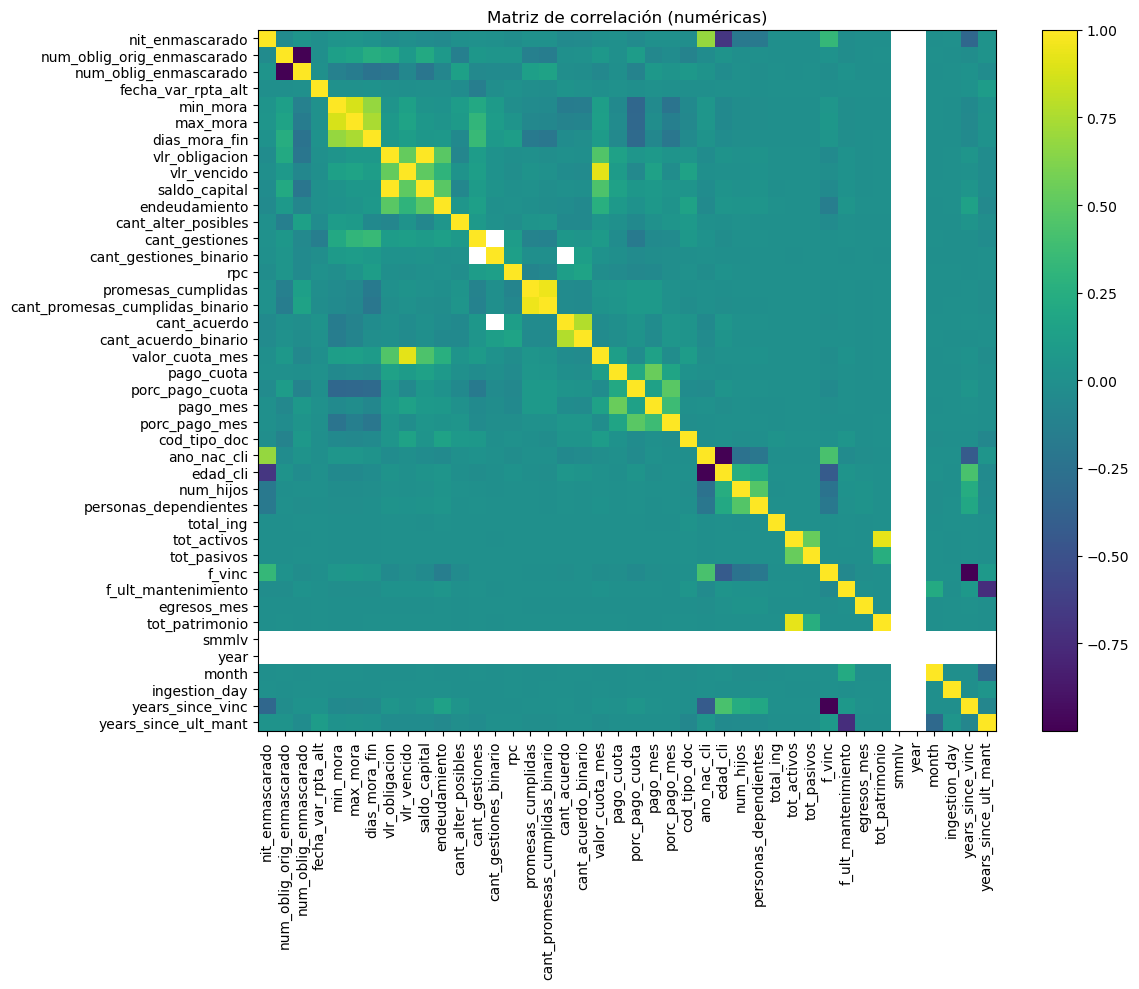


Pares de variables con |correlación| > 0.5:
num_oblig_enmascarado ↔ num_oblig_orig_enmascarado: -1.00
max_mora ↔ min_mora: 0.88
dias_mora_fin ↔ min_mora: 0.69
dias_mora_fin ↔ max_mora: 0.74
vlr_vencido ↔ vlr_obligacion: 0.53
saldo_capital ↔ vlr_obligacion: 1.00
saldo_capital ↔ vlr_vencido: 0.51
cant_promesas_cumplidas_binario ↔ promesas_cumplidas: 0.95
cant_acuerdo_binario ↔ cant_acuerdo: 0.77
valor_cuota_mes ↔ vlr_vencido: 0.92
pago_mes ↔ pago_cuota: 0.54
ano_nac_cli ↔ nit_enmascarado: 0.69
edad_cli ↔ nit_enmascarado: -0.69
edad_cli ↔ ano_nac_cli: -1.00
tot_pasivos ↔ tot_activos: 0.54
tot_patrimonio ↔ tot_activos: 0.93
years_since_vinc ↔ f_vinc: -1.00
years_since_ult_mant ↔ f_ult_mantenimiento: -0.74


In [ ]:
#EDA en df_train_valid
df = df_train_valid

# Porcentaje de valores faltantes
missing_pct = df.isna().mean().sort_values(ascending=False)
print("Porcentaje de valores faltantes (top 25):")
print(missing_pct.head(25))

# Cardinalidad de variables
unique_counts = df.nunique().sort_values(ascending=False)
print("\nNúmero de valores únicos (top 20):")
print(unique_counts.head(20))

# Estadísticas descriptivas numéricas
print("\nEstadísticas descriptivas (numéricas):")
print(df.describe().T.head(20))

# Matriz de correlación numérica
num_feats = df.select_dtypes(include=[np.number]).drop(columns=['var_rpta_alt'], errors='ignore')
corr = num_feats.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (numéricas)")
plt.tight_layout()
plt.show()

# Pares con alta correlación (>0.5)
threshold_corr = 0.5
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold_corr:
            high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
print("\nPares de variables con |correlación| > 0.5:")
for var1, var2, val in high_corr:
    print(f"{var1} ↔ {var2}: {val:.2f}")

In [145]:
# Eliminacion de variables por inspeccion 
cols_to_drop = [
    'smmlv', 'year', 'month', 'ingestion_day', 'ingestion_date_dt',
    'is_month_end', 'f_vinc_str', 'f_ult_str', 'f_vinc_date', 'f_ult_date',
    'f_vinc', 'f_ult_mantenimiento', 'ano_nac_cli', 'min_mora', 'max_mora',
    'num_oblig_orig_enmascarado', 'vlr_obligacion', 'cant_promesas_cumplidas_binario',
    'cant_acuerdo_binario', 'valor_cuota_mes', 'tot_patrimonio','tipo_var_rpta_alt',
    'banca', 'segmento', 'producto', 'producto_cons','rango_mora','desc_alternativa1',
    'desc_alternativa2','desc_alternativa3','cant_alter_posibles','alter_posible1_2',
    'descripcion_ranking_mejor_ult','descripcion_ranking_post_ult','marca_alt_rank', 
    'marca_alt_apli','marca_alternativa','marca_alternativa_orig','fecha_var_rpta_alt', 
    'cod_tipo_doc','tipo_cli', 'ctrl_terc','cant_gestiones_binario','cli_actualizado', 
    'segm', 'subsegm', 'region_of','origen_fondos','nombre_dpto_dirp','aplicativo'
]

# Eliminar de train_valid
df_train_valid = df_train_valid.drop(columns=cols_to_drop, errors='ignore')

# Verifica
print("Nuevo shape:", df_train_valid.shape)

Nuevo shape: (467785, 44)


In [ ]:
# Eliminar columnas alto faltantes
threshold_miss = 0.22
cols_to_drop = missing_pct[missing_pct > threshold_miss].index.tolist()
print(f"Columnas a eliminar (> {threshold_miss*100:.0f}% missing):")
print(cols_to_drop)

# Eliminar columnas del DataFrame
df_train_valid.drop(columns=cols_to_drop, inplace=True)

# Verificar nueva forma y porcentaje de missing restante
print("\nNueva forma:", df_train_valid.shape)
print("Top 10 valores faltantes tras drop:")
print(df_train_valid.isna().mean().sort_values(ascending=False).head(10))

Columnas a eliminar (> 22% missing):
['tipo_vivienda', 'nivel_academico', 'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'nicho', 'alter_posible3_2', 'alter_posible2_2', 'porc_pago_mes', 'canal_actualizacion', 'estado_civil', 'sector', 'ciiu', 'subsector', 'act_econom', 'ocup']

Nueva forma: (467785, 29)
Top 10 valores faltantes tras drop:
genero_cli               0.217467
personas_dependientes    0.217440
num_hijos                0.217437
edad_cli                 0.217437
declarante               0.197106
tot_pasivos              0.196849
tot_activos              0.196849
total_ing                0.196849
years_since_vinc         0.196849
egresos_mes              0.196849
dtype: float64


In [ ]:
# Identificar variables categóricas
cat_feats = df_train_valid.select_dtypes(include=['object','category']).columns.tolist()

# Calcular y mostrar cardinalidades
cardinalities = {col: df_train_valid[col].nunique() for col in cat_feats}

print("Cardinalidad de variables categóricas:")
for feat, card in sorted(cardinalities.items(), key=lambda x: -x[1]):
    print(f"{feat}: {card}")

Cardinalidad de variables categóricas:
marca_pago: 4
pagos_tanque: 2
marca_debito_mora: 2
genero_cli: 2
declarante: 2


In [ ]:
# Variables categóricas binarias a transformar
binary_vars = ['pagos_tanque', 'marca_debito_mora', 'genero_cli', 'declarante']

# Factorizar cada una para crear columna _bin
for var in binary_vars:
    codes, uniques = pd.factorize(df_train_valid[var])
    df_train_valid[f"{var}_bin"] = codes
# Eliminar variables categóricas originales
df_train_valid.drop(columns=binary_vars, inplace=True)

# Codificación específica para marca_pago
mapping = {
    'Sin pago': 0,
    'Pago parcial': 1,
    'Cumple compromiso': 2,
    'Pago Total': 3
}
df_train_valid['marca_pago_enc'] = df_train_valid['marca_pago'].map(mapping)
df_train_valid.drop(columns=['marca_pago'], inplace=True)

# 4️⃣ Verificar resultados
print("Shape df ")
print(df_train_valid.shape)
print("Nuevas columnas binarias y codificadas:")
print([col for col in df_train_valid.columns if col.endswith('_bin') or col == 'marca_pago_enc'])

print("\nEjemplo de codificaciones (primeras filas):")
print(df_train_valid[['pagos_tanque_bin','marca_debito_mora_bin',
                      'genero_cli_bin','declarante_bin','marca_pago_enc']].head())

Shape df 
(467785, 29)
Nuevas columnas binarias y codificadas:
['pagos_tanque_bin', 'marca_debito_mora_bin', 'genero_cli_bin', 'declarante_bin', 'marca_pago_enc']

Ejemplo de codificaciones (primeras filas):
   pagos_tanque_bin  marca_debito_mora_bin  genero_cli_bin  declarante_bin  \
0                 0                      0               0               0   
1                 1                      0               1               0   
2                 1                      0               0               0   
3                 1                      0               0               0   
4                 1                      0               0               1   

   marca_pago_enc  
0               1  
1               2  
2               0  
3               0  
4               0  


In [ ]:
# Fecha del último mes en df_train_valid
last_month = df_train_valid['fecha_var_rpta_dt'].max()
print("Último mes para validación temporal:", last_month)

# Split de clientes (nit_enmascarado) con train_test_split
unique_ids = df_train_valid['nit_enmascarado'].unique()
train_ids, val_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
print("Clientes en train:", len(train_ids), "Clientes en val:", len(val_ids))

# Filtrar por ID
df_id_train = df_train_valid[df_train_valid['nit_enmascarado'].isin(train_ids)].copy()
df_id_val   = df_train_valid[df_train_valid['nit_enmascarado'].isin(val_ids)].copy()

# Split temporal dentro de cada subset
df_train = df_id_train[df_id_train['fecha_var_rpta_dt'] < last_month].reset_index(drop=True)
df_valid   = df_id_val  [df_id_val  ['fecha_var_rpta_dt'] == last_month].reset_index(drop=True)

# Verificar que no haya clientes repetidos
common_ids = set(df_train['nit_enmascarado']).intersection(df_val['nit_enmascarado'])
print("Clientes en común tras ambos splits:", common_ids)

# Mostrar shapes finales
print("Train shape:", df_train.shape)
print("Valid shape:", df_val.shape)

Último mes para validación temporal: 2023-11-30 00:00:00
Clientes en train: 188405 Clientes en val: 47102
Clientes en común tras ambos splits: set()
Train shape: (281641, 29)
Valid shape: (23488, 29)


Porcentaje de valores faltantes (top 20):
tipo_vivienda            0.710004
nivel_academico          0.602797
nicho                    0.584008
canal_actualizacion      0.207188
estado_civil             0.188746
sector                   0.183917
subsector                0.183917
ciiu                     0.183917
act_econom               0.181124
ocup                     0.167752
subsegm                  0.148203
genero_cli               0.143452
personas_dependientes    0.143422
edad_cli                 0.143418
num_hijos                0.143418
ano_nac_cli              0.143418
origen_fondos            0.131153
nombre_dpto_dirp         0.123744
declarante               0.121325
segm                     0.121047
dtype: float64

Estadísticas descriptivas (numéricas):
       fecha_var_rpta_alt      prop_last     prop_mean3     auto_mean3  \
count       925146.000000  923004.000000  923004.000000  923004.000000   
mean        202309.946027       0.740498       0.740222       0.530465   
s

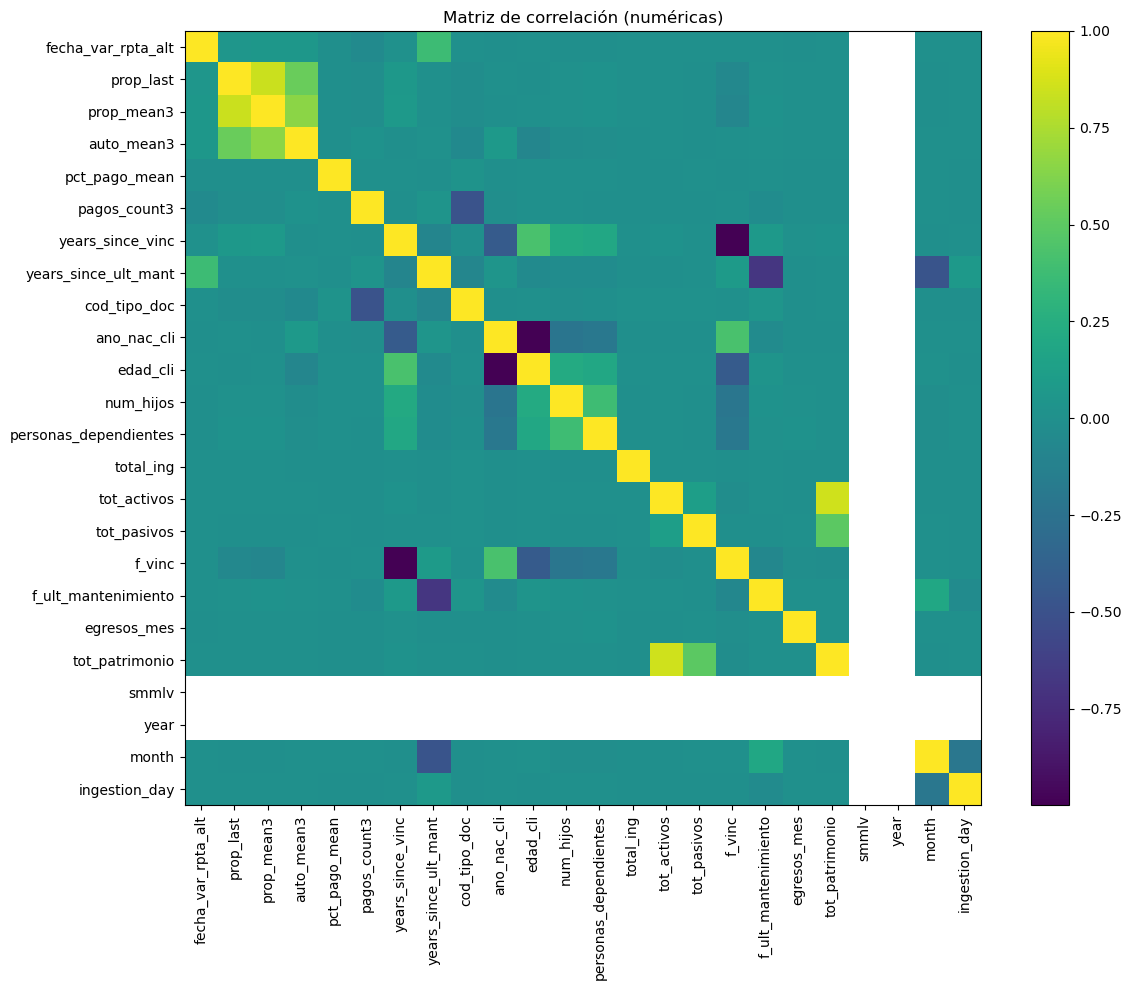

In [102]:

# Definir columnas a mantener
agg_cols = ['prop_last','prop_mean3','auto_mean3','pct_pago_mean','pagos_count3', 'years_since_vinc', 'years_since_ult_mant']
demog_cols = [col for col in master.columns if col != 'nit_enmascarado']
final_cols = ['fecha_var_rpta_alt'] + agg_cols + demog_cols + ['var_rpta_alt'] 

df_train2 = train_feat[final_cols]
df_train2v1 = df_train2.copy()

# 1️⃣ Valores faltantes
missing_pct = df_train2.isna().mean().sort_values(ascending=False)
print("Porcentaje de valores faltantes (top 20):")
print(missing_pct.head(20))

# 2️⃣ Estadísticas descriptivas
print("\nEstadísticas descriptivas (numéricas):")
print(df_train2.describe())

# 3️⃣ Cardinalidad de categóricas
cat_feats = df_train2.select_dtypes(include=['object','category']).columns.tolist()
cardinality = df_train2[cat_feats].nunique().sort_values(ascending=False)
print("\nCardinalidad (número de categorías) por variable categórica:")
print(cardinality)

# 4️⃣ Matriz de correlación entre numéricas
num_feats = df_train2.select_dtypes(include=[np.number]).drop(columns=['var_rpta_alt'])
corr = num_feats.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (numéricas)")
plt.tight_layout()
plt.show()

Columnas con >20% de missing y que se eliminarán:
['tipo_vivienda', 'nivel_academico', 'canal_actualizacion', 'nicho']
Columnas eliminadas manualmente: ['ano_nac_cli', 'f_vinc', 'f_ult_mantenimiento', 'year', 'month', 'ingestion_day', 'smmlv', 'fecha_var_rpta_alt']
df shape (925146, 33)

Valores faltantes tras eliminación (top 20):
estado_civil             0.188746
subsector                0.183917
ciiu                     0.183917
sector                   0.183917
act_econom               0.181124
ocup                     0.167752
subsegm                  0.148203
genero_cli               0.143452
personas_dependientes    0.143422
num_hijos                0.143418
edad_cli                 0.143418
origen_fondos            0.131153
nombre_dpto_dirp         0.123744
declarante               0.121325
segm                     0.121047
cli_actualizado          0.121020
tipo_cli                 0.121020
region_of                0.121020
tot_pasivos              0.121020
tot_activos         

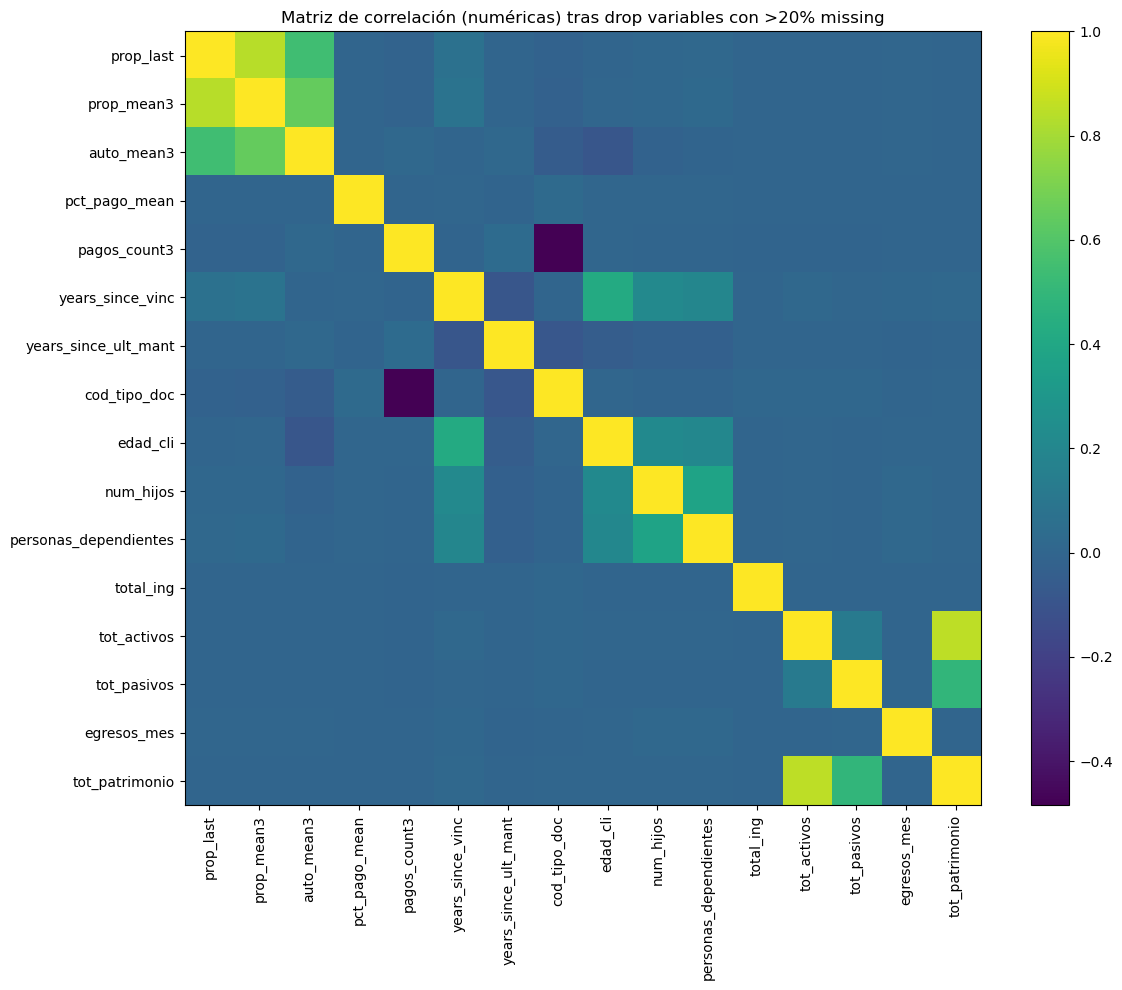

In [103]:
# Seleccion de variables relevantes

# Identificar y eliminar columnas con >20% de valores faltantes
missing_pct = df_train2.isna().mean()
to_drop = missing_pct[missing_pct > 0.2].index.tolist()
print("Columnas con >20% de missing y que se eliminarán:")
print(to_drop)

df_train2 = df_train2.drop(columns=to_drop)

# Eliminar variables no representativas y alta cardinalidad
drop_specific = [
    'ano_nac_cli', 'f_vinc', 'f_ult_mantenimiento',
    'year', 'month', 'ingestion_day', 'smmlv','fecha_var_rpta_alt'
]
df_train2.drop(columns=drop_specific, errors='ignore', inplace=True)
print("Columnas eliminadas manualmente:", drop_specific)


print(f'df shape {df_train2.shape}')
# 4️⃣ EDA sobre el dataset limpio

# 4.1️⃣ Valores faltantes (post-drop)
print("\nValores faltantes tras eliminación (top 20):")
print(df_train2.isna().mean().sort_values(ascending=False).head(20))


# 4.2️⃣ Estadísticas descriptivas
print("\nEstadísticas descriptivas (numéricas):")
print(df_train2.describe())

# 4.3️⃣ Cardinalidad de categóricas
cat_feats = df_train2.select_dtypes(include=['object','category']).columns.tolist()
print("\nCardinalidad por variable categórica:")
print(df_train2[cat_feats].nunique().sort_values(ascending=False))

# 4.4️⃣ Matriz de correlación numérica
num_feats = df_train2.select_dtypes(include=[np.number]).drop(columns=['var_rpta_alt'], errors='ignore')
corr = num_feats.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (numéricas) tras drop variables con >20% missing")
plt.tight_layout()
plt.show()



In [104]:

# 1️⃣ Identificar variables categóricas
cat_feats = df_train2.select_dtypes(include=['object','category']).columns.tolist()

# 2️⃣ Calcular cardinalidad de cada categórica
cardinality = df_train2[cat_feats].nunique()

# 3️⃣ Seleccionar aquellas con cardinalidad > 5
high_card = cardinality[cardinality > 5].index.tolist()
print("Variables categóricas con cardinalidad > 5 (a eliminar):")
print(high_card)

# 4️⃣ Eliminar del DataFrame
df_train2.drop(columns=high_card, inplace=True)

# 5️⃣ Verificar resultado
print("\nNuevo shape de df_train2:", df_train2.shape)
print("Categorías restantes con su cardinalidad:")
print(df_train2.select_dtypes(include=['object','category']).nunique())


Variables categóricas con cardinalidad > 5 (a eliminar):
['ctrl_terc', 'estado_civil', 'ocup', 'act_econom', 'sector', 'subsector', 'origen_fondos', 'segm', 'subsegm', 'region_of', 'nombre_dpto_dirp', 'ciiu']

Nuevo shape de df_train2: (925146, 21)
Categorías restantes con su cardinalidad:
tipo_cli           2
genero_cli         2
declarante         2
cli_actualizado    2
dtype: int64


In [105]:
cat_feats = df_train2.select_dtypes(include=['object','category']).columns.tolist()

# 3️⃣ Filtrar sólo las de cardinalidad 2
binary_feats = [col for col in cat_feats if df_train2[col].nunique(dropna=True) == 2]
print("Variables binarias a codificar:", binary_feats)

# 4️⃣ Mapear cada variable binaria a 0/1
for col in binary_feats:
    vals = df_train2[col].dropna().unique().tolist()
    mapping = {vals[0]: 0, vals[1]: 1}
    df_train2[col] = df_train2[col].map(mapping)

# 5️⃣ Verificar que no quedan categóricas binarias
remaining = [c for c in binary_feats if df_train2[c].dtype == 'object']
print("Quedan variables objet de cardinalidad 2 sin codificar:", remaining)

Variables binarias a codificar: ['tipo_cli', 'genero_cli', 'declarante', 'cli_actualizado']
Quedan variables objet de cardinalidad 2 sin codificar: []


In [106]:
df_train2.dtypes

prop_last                float64
prop_mean3               float64
auto_mean3               float64
pct_pago_mean            float64
pagos_count3             float64
years_since_vinc         float64
years_since_ult_mant     float64
cod_tipo_doc             float64
tipo_cli                 float64
genero_cli               float64
edad_cli                 float64
num_hijos                float64
personas_dependientes    float64
declarante               float64
total_ing                float64
tot_activos              float64
tot_pasivos              float64
cli_actualizado          float64
egresos_mes              float64
tot_patrimonio           float64
var_rpta_alt               int64
dtype: object

In [107]:
# Identificar variables binarias (0/1) excluyendo target
binary_feats = [
    col for col in df_train2.select_dtypes(include=[int, float]).columns
    if set(df_train2[col].dropna().unique()).issubset({0, 1})
    and col != 'var_rpta_alt'
]

# 2️⃣ Identificar variables continuas
cont_feats = [
    col for col in df_train2.select_dtypes(include=[int, float]).columns
    if col not in binary_feats + ['var_rpta_alt']
]

# Reemplazar inf y valores demasiado grandes en cont_feats con NaN
df_train2[cont_feats] = df_train2[cont_feats].replace([np.inf, -np.inf], np.nan)
df_train2[cont_feats] = df_train2[cont_feats].clip(lower=-1e10, upper=1e10)

# 3️⃣ Imputar continuas con MICE
mice = IterativeImputer(random_state=0, max_iter=10, initial_strategy='median')
df_cont = pd.DataFrame(
    mice.fit_transform(df_train2[cont_feats]),
    columns=cont_feats,
    index=df_train2.index
)

# 4️⃣ Imputar binarias con la moda
mode_imp = SimpleImputer(strategy='most_frequent')
df_bin = pd.DataFrame(
    mode_imp.fit_transform(df_train2[binary_feats]),
    columns=binary_feats,
    index=df_train2.index
).astype(int)

# 5️⃣ Reensamblar con target
df_train2_imputed = pd.concat([df_cont, df_bin, df_train2[['var_rpta_alt']]], axis=1)

# 6️⃣ Confirmar que no hay missing
print("Missing values after imputation:")
print(df_train2_imputed.isna().sum().loc[lambda x: x>0])


c:\Users\boris\anaconda3\envs\myenv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Missing values after imputation:
Series([], dtype: int64)


In [108]:
df_train2.columns

Index(['prop_last', 'prop_mean3', 'auto_mean3', 'pct_pago_mean',
       'pagos_count3', 'years_since_vinc', 'years_since_ult_mant',
       'cod_tipo_doc', 'tipo_cli', 'genero_cli', 'edad_cli', 'num_hijos',
       'personas_dependientes', 'declarante', 'total_ing', 'tot_activos',
       'tot_pasivos', 'cli_actualizado', 'egresos_mes', 'tot_patrimonio',
       'var_rpta_alt'],
      dtype='object')

In [114]:

# 2️⃣ Crea la fecha de evaluación (primer día del mes)
df_val['fecha_var_rpta_dt'] = pd.to_datetime(
    df_val['fecha_var_rpta_alt'].astype(int).astype(str) + '01',
    format='%Y%m%d',
    errors='coerce'
)

# 3️⃣ Limpia y convierte f_vinc y f_ult_mantenimiento
df_val['f_vinc_str'] = df_val['f_vinc'].astype(str).str.replace(r'\.0$','',regex=True)
df_val['f_ult_mant_str'] = df_val['f_ult_mantenimiento'].astype(str).str.replace(r'\.0$','',regex=True)

df_val['f_vinc_date'] = pd.to_datetime(df_val['f_vinc_str'], format='%Y%m%d', errors='coerce')
df_val['f_ult_mant_date'] = pd.to_datetime(df_val['f_ult_mant_str'], format='%Y%m%d', errors='coerce')

# 4️⃣ Calcula los años transcurridos
df_val['years_since_vinc'] = (
    (df_val['fecha_var_rpta_dt'] - df_val['f_vinc_date']).dt.days / 365.25
).round(2)
df_val['years_since_ult_mant'] = (
    (df_val['fecha_var_rpta_dt'] - df_val['f_ult_mant_date']).dt.days / 365.25
).round(2)

# 5️⃣ Limpia las columnas temporales
df_val.drop(columns=[
    'fecha_var_rpta_dt',
    'f_vinc_str','f_ult_mant_str',
    'f_vinc_date','f_ult_mant_date'
], inplace=True)

cat_feats = df_val.select_dtypes(include=['object','category']).columns.tolist()
print("Variables categóricas a imputar:", cat_feats)

# Usamos la moda para imputar categóricas
cat_imp = SimpleImputer(strategy='most_frequent')
df_val[cat_feats] = cat_imp.fit_transform(df_val[cat_feats])

# 7️⃣ Alinear validación a las mismas columnas que en training
cols_required = cont_feats + binary_feats + ['var_rpta_alt']
df_val_clean = df_val[cols_required].dropna().reset_index(drop=True)

print("Shape final validación tras imputación categóricas y dropna:", df_val_clean.shape)

# Ahora df_val ya cuenta con 'years_since_vinc' y 'years_since_ult_mant'.
# Puedes volver a alinear:
cols_required = cont_feats + binary_feats + ['var_rpta_alt']
df_val_clean = df_val[cols_required].dropna().reset_index(drop=True)

print("Nuevas columnas en df_val:", cols_required)
print("Shape final validación:", df_val_clean.shape)

KeyError: 'fecha_var_rpta_alt'

In [110]:
train_cols = df_train2_imputed.columns.to_list()

df_val= df_val.reindex(columns=train_cols)

# Verificamos
missing = df_val.columns.difference(df_train.columns)
print("¿Hay alguna columna en validación que no esté en train?", missing.tolist())
print("Shape train:", df_train2.shape)
print("Shape valid:", df_val.shape)


¿Hay alguna columna en validación que no esté en train? ['years_since_ult_mant', 'years_since_vinc']
Shape train: (925146, 21)
Shape valid: (184684, 21)


In [111]:

# 1️⃣ Identificar variables categóricas
cat_feats = df_val.select_dtypes(include=['object','category']).columns.tolist()

# 2️⃣ Calcular cardinalidad de cada categórica
cardinality = df_val[cat_feats].nunique()

# 3️⃣ Seleccionar aquellas con cardinalidad > 5
high_card = cardinality[cardinality > 5].index.tolist()
print("Variables categóricas con cardinalidad > 5 (a eliminar):")
print(high_card)

# 4️⃣ Eliminar del DataFrame
df_val.drop(columns=high_card, inplace=True)

# 5️⃣ Verificar resultado
print("\nNuevo shape de df_train2:", df_val.shape)
print("Categorías restantes con su cardinalidad:")
print(df_val.select_dtypes(include=['object','category']).nunique())

Variables categóricas con cardinalidad > 5 (a eliminar):
[]

Nuevo shape de df_train2: (184684, 21)
Categorías restantes con su cardinalidad:
tipo_cli           2
genero_cli         2
declarante         2
cli_actualizado    2
dtype: int64


In [ ]:
# 2️⃣ Separar features y target
X_train = df_train2_imputed.drop("var_rpta_alt", axis=1)
y_train = df_train2_imputed["var_rpta_alt"]
X_val = df_val_clean.drop("var_rpta_alt", axis=1)
y_val = df_val_clean["var_rpta_alt"]

# 3️⃣ Entrenar Random Forest base
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 4️⃣ Predicción y probabilidades en validación
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

# 5️⃣ Métricas de rendimiento
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

print(f"Baseline Random Forest\nF1 Score: {f1:.4f}\nAUC: {auc:.4f}")


ValueError: could not convert string to float: 'PERSONA NATURAL'

In [ ]:
# Gini importance (feature_importances_)
gini_importances = pd.DataFrame({
    "feature": X_train.columns,
    "gini_importance": clf.feature_importances_
}).sort_values("gini_importance", ascending=False)

print("Top 10 Gini Importances:")
print(gini_importances.head(25))

# 5️⃣ Permutation importance en validación (scoring='f1')
perm_results = permutation_importance(
    clf, X_val, y_val, n_repeats=10, random_state=42, scoring="f1"
)

perm_importances = pd.DataFrame({
    "feature": X_val.columns,
    "perm_mean": perm_results.importances_mean,
    "perm_std": perm_results.importances_std
}).sort_values("perm_mean", ascending=False)

print("\nTop 10 Permutation Importances (mean):")
print(perm_importances.head(25))

In [ ]:
# Convertir fechas de vinculación y último mantenimiento
for col in ['f_vinc','f_ult_mantenimiento']:
    oot_feat[col] = oot_feat[col].astype(str).str.replace(r'\.0$','',regex=True)
oot_feat['f_vinc_date'] = pd.to_datetime(oot_feat['f_vinc'], format='%Y%m%d', errors='coerce')
oot_feat['f_ult_mant_date'] = pd.to_datetime(oot_feat['f_ult_mantenimiento'], format='%Y%m%d', errors='coerce')

# Fecha de evaluación
oot_feat['fecha_var_rpta_dt'] = pd.to_datetime(
    oot_feat['fecha_var_rpta_alt'].astype(int).astype(str) + '01',
    format='%Y%m%d', errors='coerce'
)

# Calcular años desde vinculación y último mantenimiento
oot_feat['years_since_vinc'] = (
    (oot_feat['fecha_var_rpta_dt'] - oot_feat['f_vinc_date']).dt.days / 365.25
).round(2)
oot_feat['years_since_ult_mant'] = (
    (oot_feat['fecha_var_rpta_dt'] - oot_feat['f_ult_mant_date']).dt.days / 365.25
).round(2)

# 3️⃣ Preparar df_oot con cont_feats y binary_feats
df_oot = oot_feat[cont_feats + binary_feats]

# Reemplazar inf y valores extremos
df_oot[cont_feats] = df_oot[cont_feats].replace([np.inf, -np.inf], np.nan)
df_oot[cont_feats] = df_oot[cont_feats].clip(lower=-1e10, upper=1e10)

# 4️⃣ Imputar
df_oot_cont = pd.DataFrame(
    mice.transform(df_oot[cont_feats]),
    columns=cont_feats,
    index=df_oot.index
)
df_oot_bin = pd.DataFrame(
    mode_imp.transform(df_oot[binary_feats]),
    columns=binary_feats,
    index=df_oot.index
).astype(int)

df_oot_imputed = pd.concat([df_oot_cont, df_oot_bin], axis=1)